In [51]:
import stumpy, itertools, hdbscan
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import warnings
from pywaffle import Waffle
from matplotlib.patches import Rectangle, FancyArrowPatch
from sklearn.impute import KNNImputer
from itertools import cycle
from statsmodels.tsa.stattools import adfuller
from plotly_calplot import calplot

# !conda install --yes --prefix {sys.prefix} hdbscan
# data_w.to_csv(r'D:\Internship & Thesis\us_sup1.csv', index = False, header=True)

pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 7)
# # datasets
data_w = pd.read_csv("retail_data.csv").rename(columns = {"Order Date" : "Order_Date"})
data_w

Order_Date       Ship Mode Customer ID        Country           City  \
0     2014-01-03  Standard Class    DP-13000  United States        Houston   
1     2014-01-04  Standard Class    PO-19195  United States     Naperville   
2     2014-01-04  Standard Class    PO-19195  United States     Naperville   
...          ...             ...         ...            ...            ...   
9991  2017-12-30  Standard Class    PO-18865  United States  New York City   
9992  2017-12-30  Standard Class    EB-13975  United States      Fairfield   
9993  2017-12-30  Standard Class    PO-18865  United States  New York City   

           State  Postal Code   Region       Product ID         Category  ...  \
0          Texas        77095  Central  OFF-PA-10000174  Office Supplies  ...   
1       Illinois        60540  Central  OFF-LA-10003223  Office Supplies  ...   
2       Illinois        60540  Central  OFF-ST-10002743  Office Supplies  ...   
...          ...          ...      ...              ...              ...  ...   
9991    New York        10009     East  TEC-PH-10004774       Technology  ...   
9992  California        94533     West  OFF-BI-10002103  Office Supplies  ...   
9993    New York        10009     East  FUR-BO-10003441        Furniture  ...   

                                           Product Name    Sales  Quantity  \
0     Message Book, Wirebound, Four 5 1/2" X 4" Form...   16.448         2   
1                                             Avery 508   11.784         3   
2                         SAFCO Boltless Steel Shelving  272.736         3   
...                                                 ...      ...       ...   
9991                          Gear Head AU3700S Headset   90.930         7   
9992    Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl   13.904         2   
9993  Bush Westfield Collection Bookcases, Fully Ass...  323.136         4   

      Discount   Profit  Gender Age  Order Day  Order Month  Order Year  
0          0.2   5.5512       M  49          3            1        2014  
1          0.2   4.2717       M  70          4            1        2014  
2          0.2 -64.7748       M  70          4            1        2014  
...        ...      ...     ...  ..        ...          ...         ...  
9991       0.0   2.7279       F  48         30           12        2017  
9992       0.2   4.5188       M  28         30           12        2017  
9993       0.2  12.1176       F  48         30           12        2017  

[9994 rows x 21 columns]

<span style="color:Green; font-family:Lucida Console; font-size:2em;"> Part I: Exploratory Data Analysis </span>

In [3]:
# Stanley Diagram
df = data_w[["Category", "Sub-Category", "Sales", "Profit"]]
fig = px.treemap(df, path = ["Category", "Sub-Category"], values = "Sales", width = 800, height = 400, color = "Profit",
                  color_continuous_scale='PuOr',
                  title = "Sales Size & Profit Revenue",
                  color_continuous_midpoint=np.average(df["Profit"], weights=df["Sales"]))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

C:\Users\aljal\AppData\Local\Temp\ipykernel_222904\3178600694.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




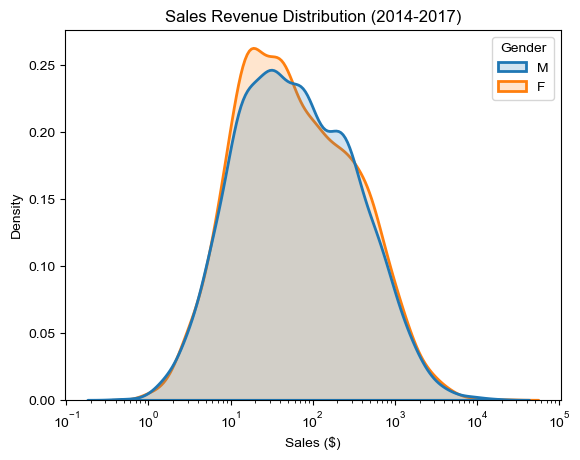

<Figure size 2000x2000 with 0 Axes>

In [ ]:
sns.kdeplot(data = data_w, x = "Sales", hue = "Gender", shade=True, log_scale = True, alpha=.2, linewidth=2).set(xlabel="Sales ($)")
plt.title("Sales Revenue Distribution (2014-2017)")
sns.set(style="darkgrid")
plt.figure(figsize=(20, 20))
sns.set(font_scale = 1.2)
plt.show()

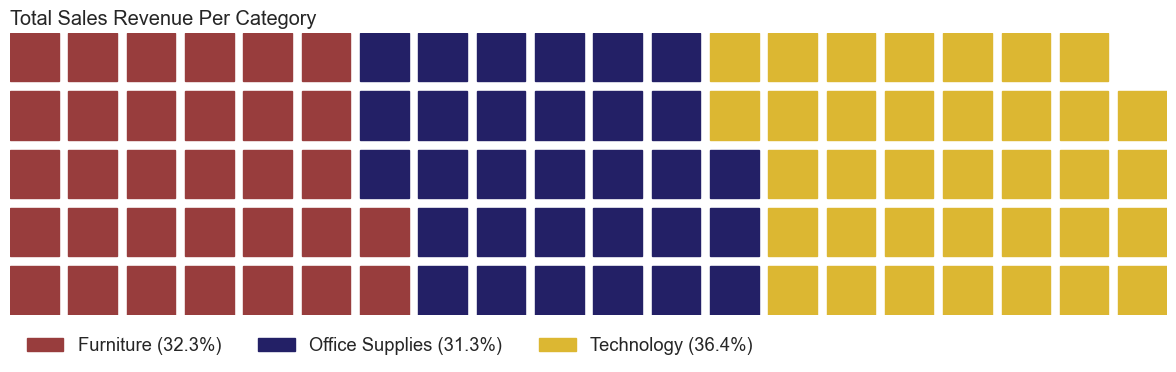

In [ ]:
waf_data = data_w[["Category", "Sales"]].groupby(["Category"]).agg({"Sales" : "sum"})
total = sum(waf_data["Sales"])
proportions = [round((float(value) / total)*100, 2) for value in waf_data["Sales"]] # % of category sales each
waf_data["Proportions"] = proportions
waf_data = waf_data.drop(["Sales"], axis = 1)
waf_data = waf_data["Proportions"].to_dict()
fig = plt.figure(FigureClass=Waffle, rows=5, values=waf_data, figsize=(12, 8),
    colors=("#983D3D", "#232066", "#DCB732"),
    title={"label": "Total Sales Revenue Per Category", "loc": "left"},
    labels=["{0} ({1}%)".format(k, v) for k, v in waf_data.items()],
    legend={"loc": "lower left", "bbox_to_anchor": (0, -0.2), "ncol": len(waf_data), "framealpha": 0})
plt.show()

In [ ]:
# calplot for plotly
cal_data = data_w[["Order_Date", "Sales"]]
cal_data["Order_Date"] =  cal_data.Order_Date
cal_data = cal_data.sort_values(by="Order_Date")
# cal_data

fig = calplot(
    cal_data,
    x="Order_Date",
    y="Sales",
    dark_theme=False,
    years_title=True,
    colorscale="blues",
    gap=4,
    name="Sales ($)",
    month_lines_width=4, 
    month_lines_color="#fff",
    title = "Sales Revenue Per Day"
)
fig.show()

C:\Users\aljal\AppData\Local\Temp\ipykernel_222904\3614935325.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



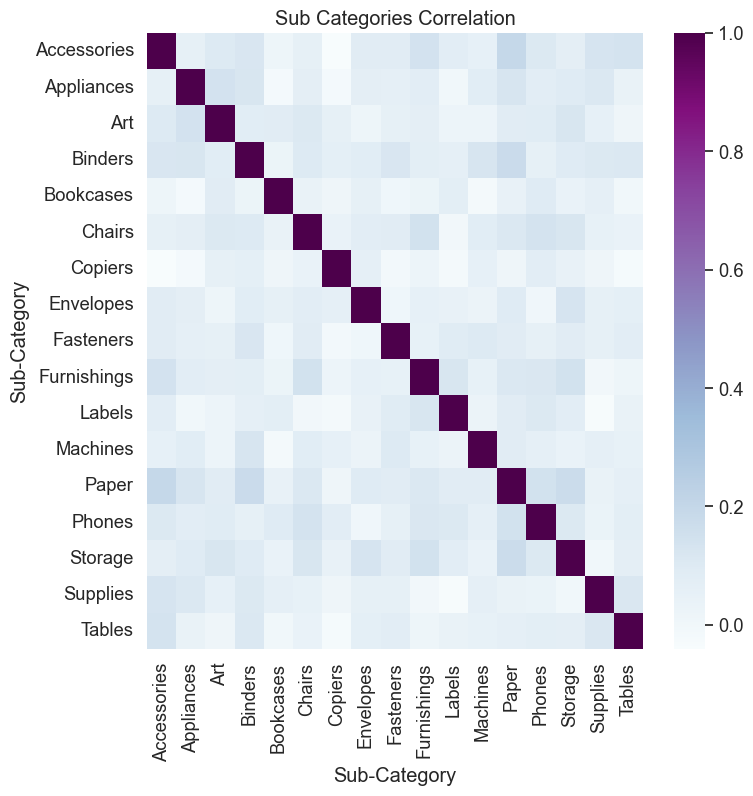

In [7]:
def max_scaling(df):
    for column in df.columns:
        df[column] = df[column]  / df[column].abs().max()
    return df

data_u = data_w[["Customer ID", "Sub-Category", "Sales"]].groupby(["Customer ID", "Sub-Category"]).agg({"Sales" : "sum"})
data_u = max_scaling(data_u.pivot_table(index = ["Customer ID"], columns = "Sub-Category", values = "Sales", fill_value = 0)).reset_index().set_index("Customer ID")
# data_u_n = data_u.drop(["Gender", "Age"], axis = 1)
corrMatrix = data_u.corr(method = "spearman") # choosing spearman, as it suits the data context
fig = plt.figure(figsize=(8,8))
r = sns.heatmap(corrMatrix, cmap = "BuPu")
r.set_title("Sub Categories Correlation")
plt.show()

<span style="color:Green; font-family:Lucida Console; font-size:2em;">Part II: Data Pre-Processing</span>

### Time Series Regularization

In [8]:
#regulating
ts_data = data_w[["Order_Date", "Sub-Category", "Sales"]].groupby(["Order_Date", "Sub-Category"]).agg({"Sales" : "sum"})
ts_data = ts_data.pivot_table(index = ["Order_Date"], columns = "Sub-Category", values = "Sales").reset_index()
timeframe = pd.DataFrame(pd.date_range(ts_data['Order_Date'].min(), ts_data['Order_Date'].max()), columns=['Order_Date'])
ts_data['Order_Date'] = pd.to_datetime(ts_data['Order_Date'])
ts_data_d = pd.merge(timeframe, ts_data, how="left", on = "Order_Date").set_index('Order_Date')

### KNN Imputation

In [9]:
# Filling missing values with KNN
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
ts_data_d = pd.DataFrame(imputer_knn.fit_transform(ts_data_d), columns=ts_data_d.columns, index = ts_data_d.index)
ts_data_d

Accessories  Appliances      Art   Binders  Bookcases     Chairs  \
Order_Date                                                                     
2014-01-03     349.2008     44.9028  71.3900  395.9252  407.35112  1078.4488   
2014-01-04     291.4608    148.3008  19.4412    3.5400  389.50960   310.7302   
2014-01-05     447.2672    590.8608  19.5360   45.6080  523.89700  1383.6484   
...                 ...         ...      ...       ...        ...        ...   
2017-12-28      44.1408    109.3316  29.6480   62.0320   78.85280   454.0760   
2017-12-29      75.2876    170.7764  34.5800   12.5300  501.06040  2161.1380   
2017-12-30      87.9912    209.3000  35.8824   87.4000  323.13600   504.1848   

              Copiers  Envelopes  Fasteners  Furnishings   Labels   Machines  \
Order_Date                                                                     
2014-01-03  3039.9664   101.9672    16.4084     225.1104  22.4968  2151.4408   
2014-01-04  2415.9752     7.8864     7.6208     113.1232  11.7840  2023.6422   
2014-01-05   927.9800   111.9840    16.6784     123.6664  41.6832   478.2974   
...               ...        ...        ...          ...      ...        ...   
2017-12-28   699.9788   214.5892    13.9600      18.3280  72.4500  1246.6530   
2017-12-29  2743.9776    70.3440    25.6300     169.5800  11.4736  2648.4654   
2017-12-30  1295.9688    76.0412     3.0240     169.6884  26.6916  2720.0946   

               Paper    Phones   Storage   Supplies     Tables  
Order_Date                                                      
2014-01-03   16.4480  450.4552  153.6616    65.9188   630.1482  
2014-01-04   26.2752  312.8080  272.7360    26.5412   397.8690  
2014-01-05  186.1672  871.6668  515.7732  1299.2720  1043.9518  
...              ...       ...       ...        ...        ...  
2017-12-28    4.2800   14.8500  908.8740    70.8548   626.2634  
2017-12-29  209.7000  302.3760  596.2740    58.4172  1060.0536  
2017-12-30   52.5408   90.9300  302.8632    27.1844   761.5614  

[1458 rows x 17 columns]

### Month level aggregation

In [10]:
# Month level aggregation
dicti = {c: "sum" for i, c in enumerate(ts_data_d.columns)}
ts_data_m = ts_data_d.resample('ME').agg(dicti)
ts_data_m

Accessories    Appliances          Art       Binders  \
Order_Date                                                          
2014-01-31  10000.725185   7375.255830  1092.338325   4944.574474   
2014-02-28   9500.775869   7091.947349  1175.710657   4006.071285   
2014-03-31   8850.374385   9106.050230  1123.153525   6644.440274   
...                  ...           ...          ...           ...   
2017-10-31   9384.902051   8839.702356  1435.896996  13157.308232   
2017-11-30  11000.584800   9811.425000  1711.808400   7444.920400   
2017-12-31   8869.542284  10242.436519  1312.389932   6483.470811   

               Bookcases        Chairs       Copiers    Envelopes  Fasteners  \
Order_Date                                                                     
2014-01-31  14096.819471  26687.459391  68013.669093  2448.431580   442.4516   
2014-02-28  14696.089812  23280.918704  66611.514734  2458.426606   424.2872   
2014-03-31  16813.685051  22509.425791  65403.599893  2406.511180   474.9424   
...                  ...           ...           ...          ...        ...   
2017-10-31  16303.697744  20156.890539  73686.423725  2536.483477   438.4584   
2017-11-30  12146.969900  23226.756200  82681.150000  2130.503600   477.5132   
2017-12-31  12544.940001  24722.095513  62986.901642  2087.879026   475.8388   

            Furnishings       Labels      Machines        Paper        Phones  \
Order_Date                                                                      
2014-01-31  3644.552513  1072.012938  57129.575548  2261.749532  16305.761464   
2014-02-28  4190.316815   780.590786  48643.441969  2664.848493  14408.721673   
2014-03-31  4934.167713  1244.869338  87216.566348  3257.360732  17007.992664   
...                 ...          ...           ...          ...           ...   
2017-10-31  3666.205306  1012.827145  52754.755663  3026.370885  16130.222227   
2017-11-30  7738.774800   790.086400  59833.119800  4960.283600  21874.232800   
2017-12-31  5035.955502   802.221448  63321.094021  4444.452962  14069.207809   

                 Storage      Supplies        Tables  
Order_Date                                            
2014-01-31  11421.235935   9335.361653  19602.719379  
2014-02-28  10666.751355   8031.842633  22019.240333  
2014-03-31  11812.331935   6619.502453  25229.854179  
...                  ...           ...           ...  
2017-10-31  12414.253458  14826.359337  20633.687862  
2017-11-30  15707.372800   6385.243600  25140.961400  
2017-12-31  14206.887819   8848.719779  22887.282554  

[48 rows x 17 columns]

### Non-Stationarity Detection: Graphs

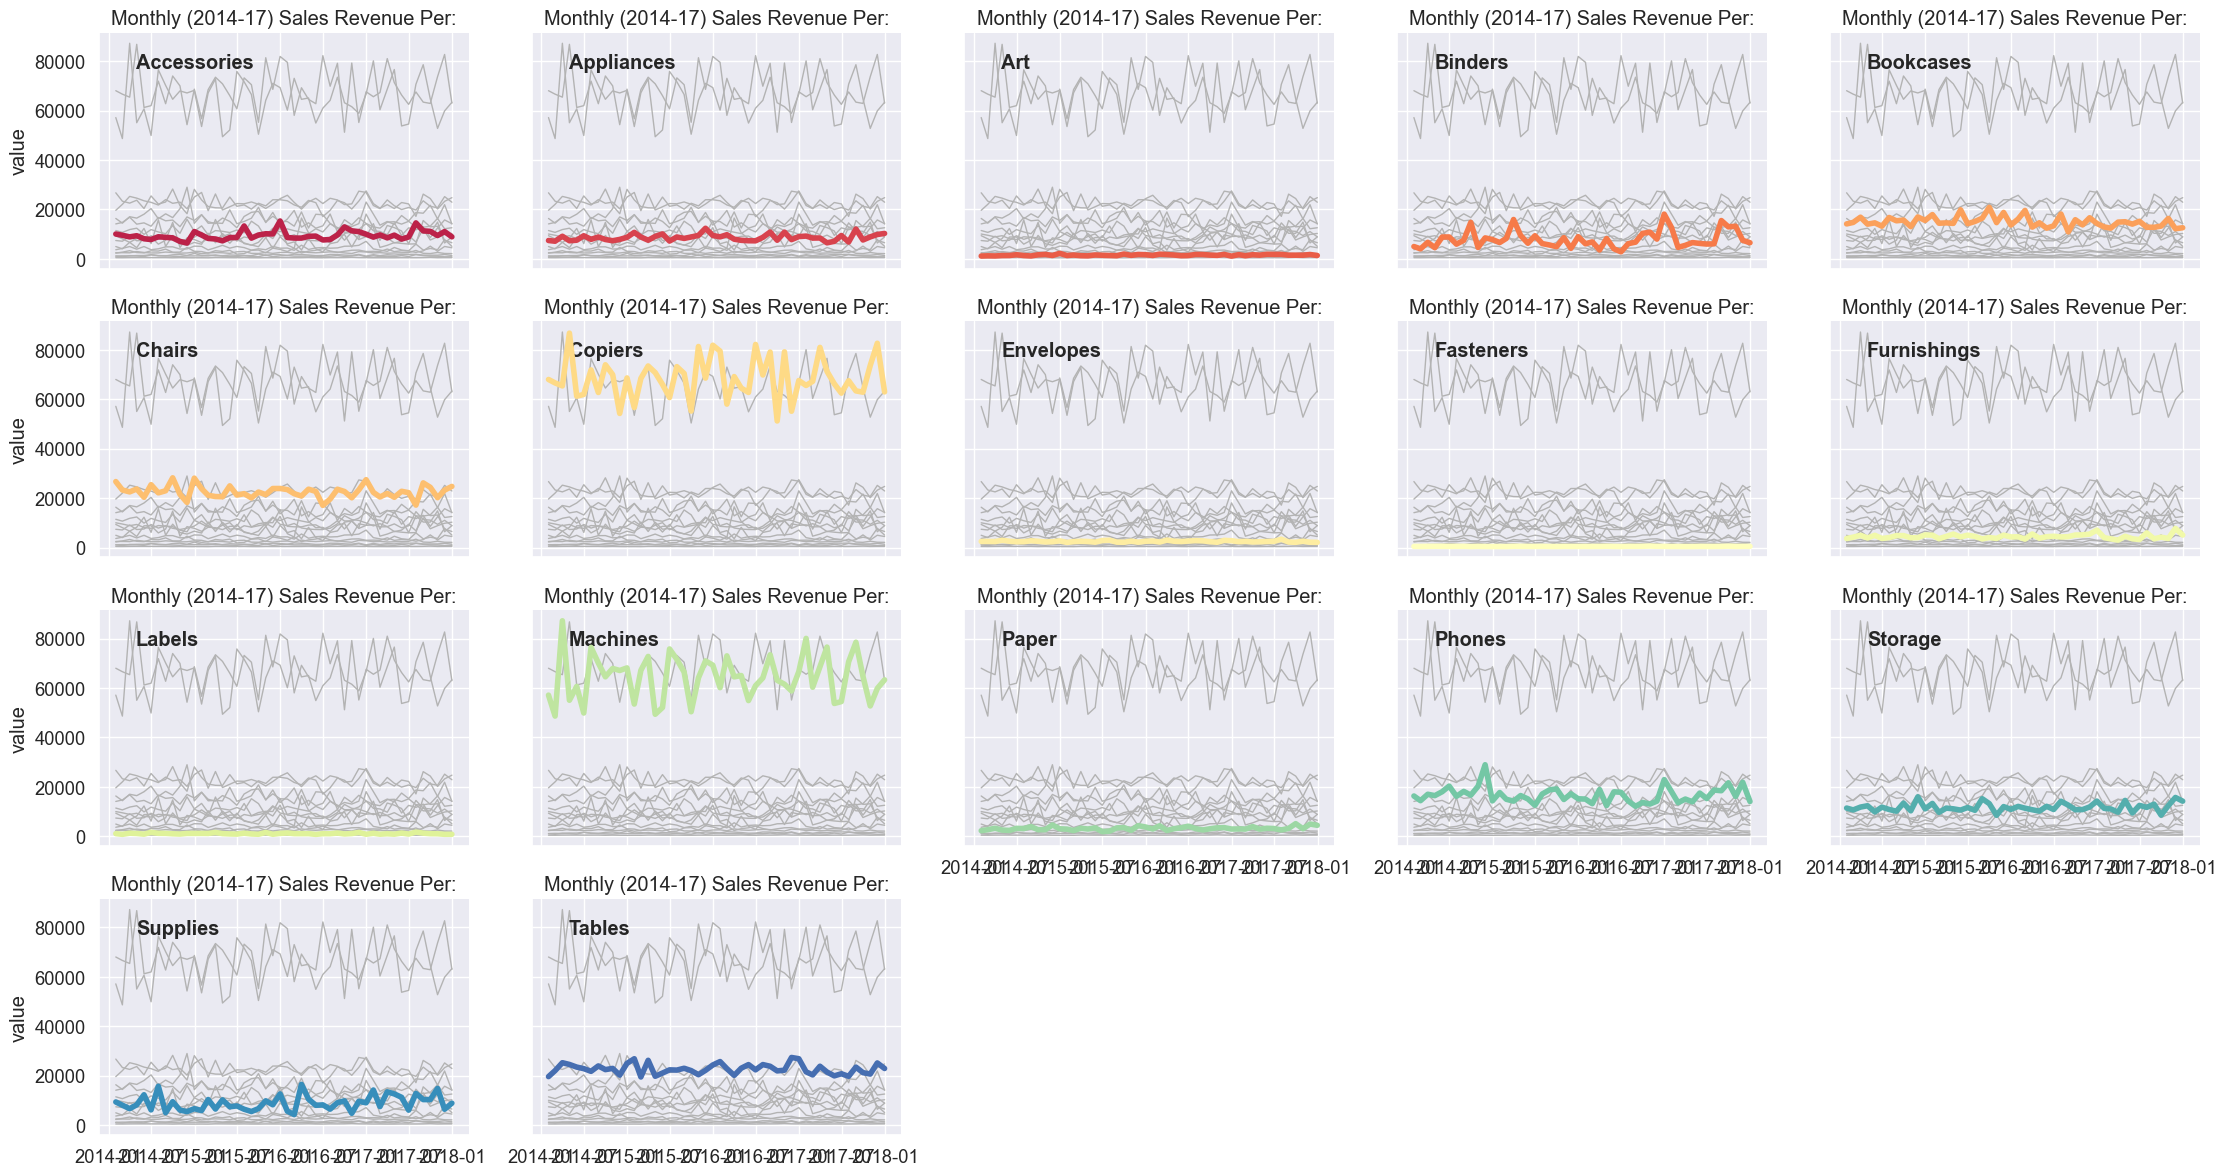

In [11]:
# # ---------Soft test: Graphs-----------------
ts_data_m_l = ts_data_m.reset_index()
ts_data_m_l = pd.melt(ts_data_m_l, id_vars='Order_Date', value_vars=list(ts_data_m_l.columns)).rename(columns={"variable": "Category"})
ts_data_m_l
g = sns.relplot(data = ts_data_m_l, x = "Order_Date", y = "value",
                col = "Category", hue = "Category",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 5, height = 3, aspect = 1.5, legend = False
               )
#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = ts_data_m_l, x = "Order_Date", y = "value", units="Category",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )
g.set_titles("Monthly (2014-17) Sales Revenue Per:")
g.set_axis_labels("", "value")
g.tight_layout()
plt.show()

### Non-Stationarity Detection: Adfuller Test


In [12]:
def label_stationary (row):
    if row['p_value'] <= 0.05:
        return 'Stationary'
    else:
        return 'Not Stationary'
def highlight(s):
    if s.p_value > 0.05:
        return ['background-color: tomato'] * len(s)
    else:
        return ['background-color: white'] * len(s)
adf_results = {}
for col in ts_data_m.columns.values: 
    adf_results[col] = round(adfuller(ts_data_m[col])[1], 5)
p_value = pd.DataFrame(adf_results.items(), columns=['Category', 'p_value'])
p_value['Stationarity (5% Sign. Level)'] = p_value.apply (lambda row: label_stationary(row), axis=1)
p_value.style.apply(highlight, axis=1)
# p_value <= 0.05: Reject the null hypothesis (not stationary)

### Non-Stationarity Removal & Scaling


In [13]:
diff_ord = 1
cols_s = []
cols_assigned_s = {}
for kol_s in ts_data_m.columns:
    if adf_results[kol_s] <= 0.05:
        continue
    cols_s.append(kol_s)
    ts_data_m["d"+kol_s] = ts_data_m[kol_s].diff(periods=1)
    cols_assigned_s['d'+ kol_s] = kol_s

ts_data_m = ts_data_m.drop(columns=cols_s, axis = 1).rename(columns = cols_assigned_s)
ts_data_m = ts_data_m.iloc[diff_ord:]
def max_scaling(df):
    for column in df.columns:
        df[column] = df[column] / df[column].abs().max()
    return df
ts_data_m_n = max_scaling(ts_data_m)
adf_results2 = {}
for col in ts_data_m_n.columns.values: 
    adf_results2[col] = round(adfuller(ts_data_m_n[col])[1], 5)
p_value = pd.DataFrame(adf_results2.items(), columns=['Category', 'p_value'])
p_value['Stationarity (5% Sign. Level)'] = p_value.apply (lambda row: label_stationary(row), axis=1)
p_value.style.apply(highlight, axis=1)

#### Normalization

In [14]:
def z_normalize(T):
    # implementation of z-normalization
    return (T - T.mean()) / T.std()

def distance_profile(Q, T): # Q: Query, T: Time Series
    return stumpy.mass(Q, T) # stumpy.core.mass

ts_data_m = ts_data_m.apply(z_normalize)
ts_data_m

Accessories  Appliances       Art   Binders    Chairs   Copiers  \
Order_Date                                                                    
2014-02-28     0.033092   -1.153317 -1.228937 -1.117899  0.353188 -0.215640   
2014-03-31    -0.325488    0.355069 -1.440129 -0.353049  0.034776 -0.360166   
2014-04-30    -0.066642   -1.018182 -0.808133 -0.984004  0.522192  2.197480   
...                 ...         ...       ...       ...       ...       ...   
2017-10-31    -0.030792    0.155598 -0.183422  1.535001 -0.936166  0.630869   
2017-11-30     0.859966    0.883333  0.925281 -0.120993  0.330834  1.707082   
2017-12-31    -0.314920    1.206122 -0.679714 -0.399713  0.947993 -0.649323   

            Envelopes  Fasteners  Furnishings    Labels  Machines     Paper  \
Order_Date                                                                    
2014-02-28  -0.036520  -0.765726    -0.299982 -1.323468 -1.768970 -0.765558   
2014-03-31  -0.221114   0.431174     0.507586  0.674754  2.545958  0.058191   
2014-04-30   1.550416   0.927606    -0.647841  0.166646 -1.051856 -0.979658   
...               ...        ...          ...       ...       ...       ...   
2017-10-31   0.241026  -0.430884    -0.868989 -0.323939 -1.309064 -0.262946   
2017-11-30  -1.202510   0.491917     3.552434 -1.282600 -0.517253  2.425705   
2017-12-31  -1.354069   0.452354     0.618093 -1.230372 -0.127075  1.708564   

              Phones   Storage  Supplies    Tables  Bookcases  
Order_Date                                                     
2014-02-28 -0.716020 -0.623123 -0.271717 -0.362449   0.197521  
2014-03-31  0.103105  0.036250 -0.733450  1.209622   0.671830  
2014-04-30 -0.073974  0.350272 -0.220935  0.864147  -0.869730  
...              ...       ...       ...       ...        ...  
2017-10-31 -0.173512  0.382704  1.949598 -1.040882   0.977188  
2017-11-30  1.636637  2.278157 -0.810035  1.166095  -1.288205  
2017-12-31 -0.823014  1.414508 -0.004657  0.062586   0.134637  

[47 rows x 17 columns]

In [ ]:


df1 = ts_data_m.reset_index().set_index('Order_Date').stack().reset_index().rename(columns={'level_1':'Sub_Categories', 0:'n'})
fig = px.line(df1, x='Order_Date', y='n', color='Sub_Categories', markers=True, title= "Sales Revenue per category (2014-17)")
fig.update_xaxes(nticks=ts_data_m.shape[0])
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
# pio.renderers.default = "notebook"
# fig.show()
# image_bytes = fig.to_image(format='png')
# Image(image_bytes)

#### Motif Chains

In [16]:
# viz of accessories
chain_data = ts_data_m.reset_index(drop=True)
raw_data_df = chain_data
raw_data_np = chain_data.to_numpy(copy=True).transpose() # t
columns = chain_data.columns.values.tolist()
sub = 'Binders'
m = 12
mp = stumpy.stump(chain_data[sub], m=m)
_, unanchored_chain = stumpy.allc(mp[:, 2], mp[:, 3])

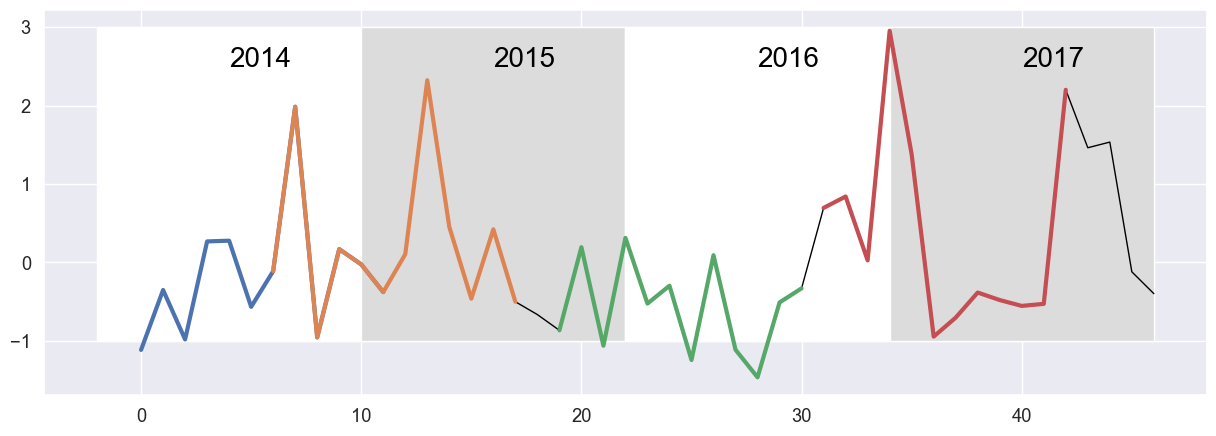

In [ ]:
plt.figure(figsize=(15,5)) 
plt.plot(chain_data[sub], linewidth=1, color='black')
for i in range(unanchored_chain.shape[0]):
    y = chain_data[sub].iloc[unanchored_chain[i]:unanchored_chain[i]+m]
    x = y.index.values
    plt.plot(x, y, linewidth=3)
color_ = itertools.cycle(['white', 'gainsboro'])
for i, x in enumerate(range(0, chain_data.shape[0], 12)):
    plt.text(x+4, 2.5, str(2014+i), color="black", fontsize=20)
    rect = Rectangle((x-2, -1), 12, 4, facecolor=next(color_))
    plt.gca().add_patch(rect)
plt.show()

In [18]:
ts_chain = {}
for c in columns:
    mp = stumpy.stump(chain_data[c], m=m)
    _, unanchored_chain = stumpy.allc(mp[:, 2], mp[:, 3])
    ts_chain[c] = []
    # if c == "Accessories":
    #     print(f"size of Accessories is {unanchored_chain.shape[0]}")
    for i in range(unanchored_chain.shape[0]):
        chain_ts = chain_data[c].iloc[unanchored_chain[i]:unanchored_chain[i]+m]
        # print(type(chain_ts.values))
        ts_chain[c].append(chain_ts.values)

ts_chain_ = []
for c in columns:
    ts_chain_.append(np.concatenate(ts_chain[c], axis = 0))

In [19]:
bookcases_idx = columns.index(sub)
ts_chain_df = pd.DataFrame(ts_chain_[bookcases_idx]).rename(columns={0:'n'})
fig = px.line(ts_chain_df, x=ts_chain_df.index, y='n')
fig.update_xaxes(nticks=ts_chain_df.shape[0])
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.show()
# image_bytes = fig.to_image(format='png')
# Image(image_bytes)

#### Consensus Motif

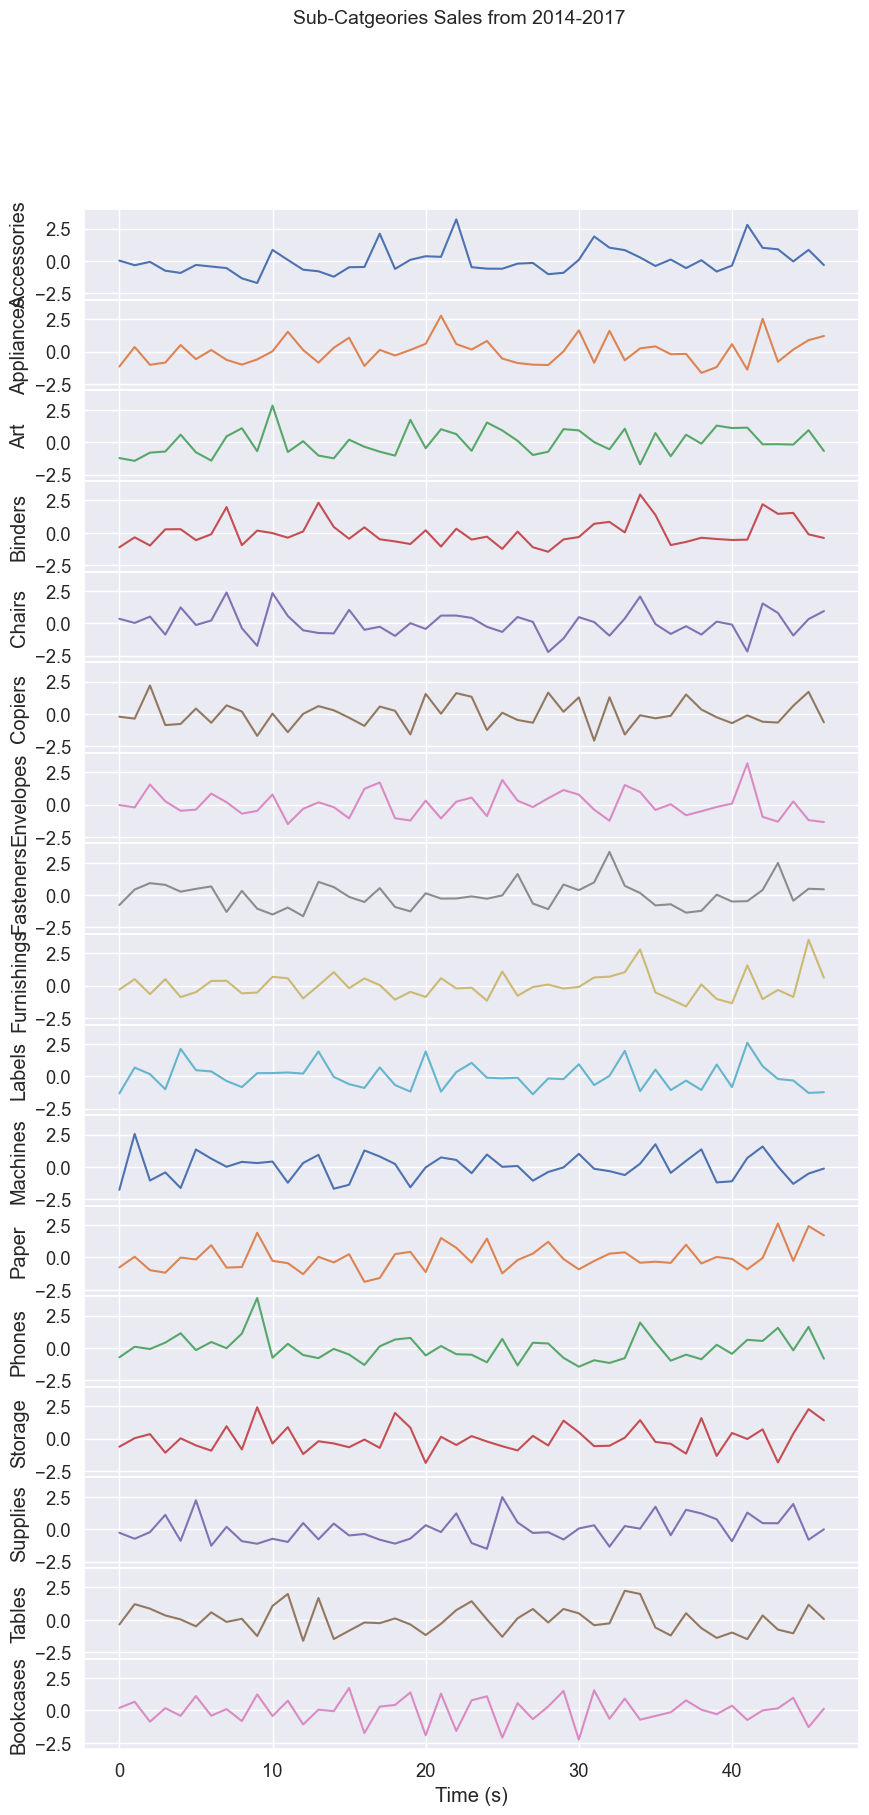

In [20]:
fs = 12
fig, ax = plt.subplots(len(columns), sharex=True, sharey=True, figsize=(10, 20))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])
for i in range(chain_data.shape[1]):
    ax[i].plot(np.arange(0, chain_data.shape[0]), chain_data[columns[i]].values, color=next(colors))
    ax[i].set_ylabel(columns[i])
    ax[i].set_ylim((-3, 4))
plt.subplots_adjust(hspace=0)
plt.xlabel('Time (s)')
plt.suptitle('Sub-Catgeories Sales from 2014-2017', fontsize=14)
plt.show()

In [21]:
consensus_ts = []
for i in range(len(columns)):
    np_ts = chain_data[columns[i]].to_numpy()
    consensus_ts.append(np_ts)
    
m = 12
radius, ref_ts_index, ref_motif_subseq_idx = stumpy.ostinato(consensus_ts, m, normalize=False)
# print(f'Found Best Radius {np.round(radius, 2)} in time series {ref_ts_index} starting at subsequence index location {ref_motif_subseq_idx}.')

In [22]:
reference_motif = consensus_ts[ref_ts_index][ref_motif_subseq_idx : ref_motif_subseq_idx + m]
consensus_motifs = np.zeros(len(consensus_ts), dtype=np.int64)
consensus_motifs[ref_ts_index] = ref_motif_subseq_idx
for i, ts in enumerate(consensus_ts):
    if i != ref_ts_index:
        consensus_motifs[i] = np.argmin(stumpy.core.mass(reference_motif, ts, normalize=False))
    else:
        continue
# consensus_motifs

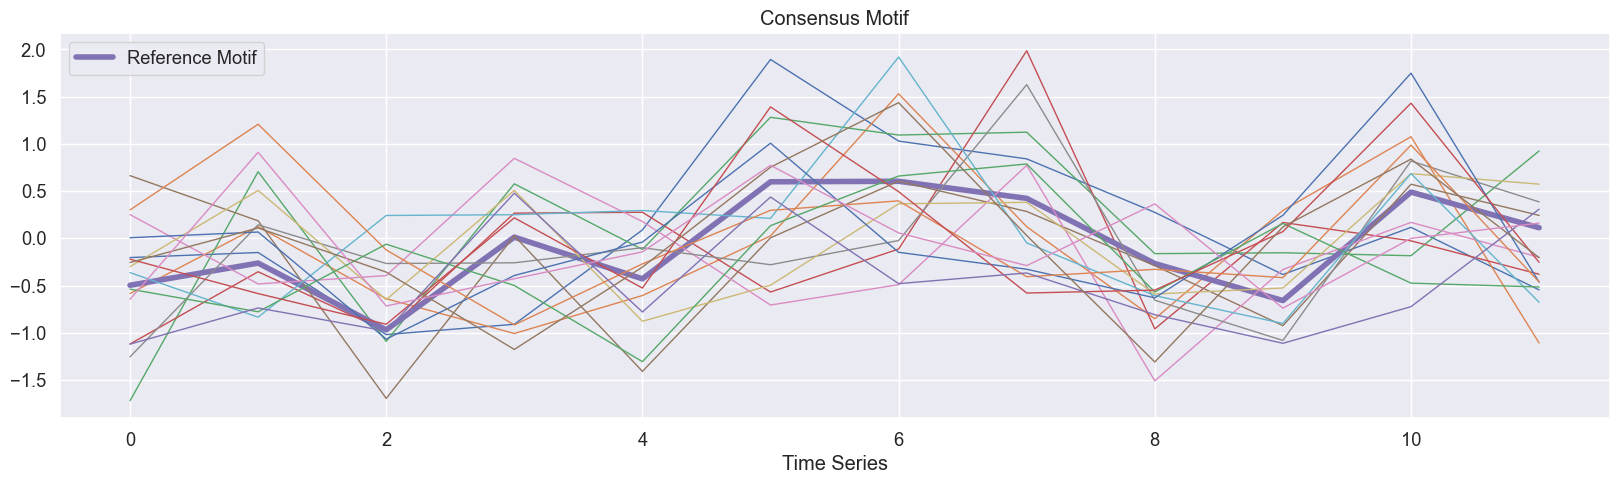

In [23]:
%matplotlib inline  
plt.figure(figsize=(20,5)) 
consensus_ts_d = {}
# consensus_ts_ = []
# x = np.linspace(0, 1, m)
for i, cs_motif_idx in enumerate(consensus_motifs):
    if i != ref_ts_index:
        lw = 1
        label = None
    else:
        lw = 4
        label = 'Reference Motif'
    consensus_fs = consensus_ts[i][consensus_motifs[i]:consensus_motifs[i]+m]
    consensus_ts_d[columns[i]] = consensus_fs
    # consensus_ts_.append(consensus_fs)
    plt.plot(consensus_fs, lw=lw, label=label)

plt.title('Consensus Motif')
# plt.figure(figsize=(8,8)) 
plt.xlabel('Time Series')
plt.legend()
# plt.figure(figsize=(8,8))
plt.show()

In [24]:
consensus_ts_df = pd.DataFrame(consensus_ts_d)
consensus_np = consensus_ts_df.transpose().to_numpy()

<span style="color:Green; font-family:Lucida Console; font-size:2em;">Part III: Clustering</span>

#### Distance Metrics

In [ ]:

def euclidean_distance(T1, T2):
    if len(T1) != len(T2):
        raise ValueError("Time series must be of the same length")
    
    return np.sqrt(np.sum((np.array(T1) - np.array(T2)) ** 2))

def dtw_distance(T1, T2):
    n, m = len(T1), len(T2)
    
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(T1[i - 1] - T2[j - 1])  
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],      
                dtw_matrix[i, j - 1],      
                dtw_matrix[i - 1, j - 1]   
            )
    
    return round(dtw_matrix[n, m], 6)

def mp_distance(T1, T2, m, k):
    return round(stumpy.mpdist(T1, T2, m, normalize = False, k = k), 6)

def dunn_index_precomputed(distance_matrix, labels):
    unique_labels = set(labels) - {-1} 
    if len(unique_labels) < 2:
        return 0
    
    intra_diameters = []
    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        if len(cluster_indices) > 1:
            cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
            intra_diameters.append(np.max(cluster_distances))
        else:
            intra_diameters.append(0)  
    
    inter_distances = []
    for label_a in unique_labels:
        for label_b in unique_labels:
            if label_a != label_b:
                indices_a = np.where(labels == label_a)[0]
                indices_b = np.where(labels == label_b)[0]
                cluster_distances = distance_matrix[np.ix_(indices_a, indices_b)]
                inter_distances.append(np.min(cluster_distances))
    
    min_inter_distance = np.min(inter_distances)
    max_intra_diameter = np.max(intra_diameters)
    
    return min_inter_distance / max_intra_diameter if max_intra_diameter > 0 else 0

def hdbscan_(distance_matrix, min_sample, select_method, min_cluster, metric = 'precomputed', mst=False):
    clusterer = hdbscan.HDBSCAN(metric=metric, min_cluster_size = min_cluster, min_samples=min_sample, cluster_selection_method=select_method, gen_min_span_tree=mst)
    model = clusterer.fit(distance_matrix)
    labels = clusterer.labels_
    dunn_score = dunn_index_precomputed(distance_matrix, labels)
    dbcv_score = hdbscan.validity.validity_index(distance_matrix, labels)
    return model, labels, dbcv_score, dunn_score

### Hyperparameter Tuning

In [ ]:
warnings.simplefilter('ignore')

def hypertuning(distance_matrix, dbcv=True, dunn=False):
    best_params = [0, 0, 0]
    dbcv_score = -1.0
    dunn_score = 0.0
    labels_ = []
    min_c_size = list(range(2, 10))
    min_sample = np.arange(1, 30, 1).tolist()
    cluster_s_method = ['eom','leaf']
    for i in range(len(min_c_size)):
        for j in range(len(min_sample)):
            for k in range(len(cluster_s_method)):
                _, lebels, dbcv, dunn = hdbscan_(distance_matrix, min_sample=min_sample[j], select_method=cluster_s_method[k], min_cluster=min_c_size[i], mst=True)
                if dbcv > dbcv_score:
                    labels_ = lebels
                    dbcv_score = dbcv
                    if dbcv:
                        best_params[0], best_params[1], best_params[2] = min_c_size[i], min_sample[j], cluster_s_method[k]
                if dunn > dunn_score:
                    labels_ = lebels
                    dunn_score = dunn
                    if dunn:
                        best_params[0], best_params[1], best_params[2] = min_c_size[i], min_sample[j], cluster_s_method[k]
    return dbcv_score, dunn_score, best_params, labels_

In [27]:
def score2clus(best_score, scores, labels, mp = False):
    k = 0
    if mp:
        idx = scores.index(best_score)
        unique_cluster_1 = np.unique(labels[idx])
        for i in range(len(unique_cluster_1)):
            if unique_cluster_1[i] != -1:
                k += 1
    else:
        for i in range(len(labels)):
            if labels[i] != -1:
                k += 1
    return k

##### Raw (Euclidean & DTW & MPDist)

In [28]:
Ts_len = 17

raw_matrix_euc = np.zeros((Ts_len, Ts_len)) # Ts raw_data
for i in range(Ts_len):
    for j in range(i+1, Ts_len):
        distance = euclidean_distance(raw_data_np[i], raw_data_np[j])
        raw_matrix_euc[i, j] = distance
        raw_matrix_euc[j, i] = distance
dbcv_raw_euc, dunn_raw_euc, params_raw_euc, labels_raw_euc = hypertuning(raw_matrix_euc)
# print(labels_raw_euc)
print(f"DBCV: {dbcv_raw_euc} | Dunn: {dunn_raw_euc} | N_Clusters: {score2clus(0, 0, labels_raw_euc, mp = False)}")

DBCV: 0.10549819954597159 | Dunn: 0.9345228673552007 | N_Clusters: 8


In [29]:
raw_matrix_dtw = np.zeros((Ts_len, Ts_len)) # Ts raw_data
for i in range(Ts_len):
    for j in range(i+1, Ts_len):
        distance = dtw_distance(raw_data_np[i], raw_data_np[j])
        raw_matrix_dtw[i, j] = distance
        raw_matrix_dtw[j, i] = distance
dbcv_raw_dtw, dunn_raw_dtw, params_raw_dtw, labelss_raw_dtw = hypertuning(raw_matrix_dtw)
print(f"DBCV: {dbcv_raw_dtw} | Dunn: {dunn_raw_dtw} | N_Clusters: {score2clus(0, 0, labelss_raw_dtw, mp = False)}")

DBCV: 0.06889076733837161 | Dunn: 0.8340611295603749 | N_Clusters: 13


In [30]:
best_raw_mp_dbcv = []
best_raw_mp_dunn = []
labels_raw_mp_ = []
m_clust = 12
for k in range(1, 10):
    raw_matrix_mp = np.zeros((Ts_len, Ts_len)) # Ts raw_data
    for i in range(Ts_len):
        for j in range(i+1, Ts_len):
            distance = mp_distance(raw_data_np[i], raw_data_np[j], m_clust, k)
            raw_matrix_mp[i, j] = distance
            raw_matrix_mp[j, i] = distance
    dbcv_raw_mp, dunn_raw_mp, params_raw_mp, labels_raw_mp = hypertuning(raw_matrix_mp)
    best_raw_mp_dbcv.append(dbcv_raw_mp)
    best_raw_mp_dunn.append(dunn_raw_mp)
    labels_raw_mp_.append(labels_raw_mp)
    # print(f"dbcv_raw_mp: {dbcv_raw_mp}, dunn_raw_mp: {dunn_raw_mp}, k: {k}")
best_raw_dbcv = max(best_raw_mp_dbcv)
best_raw_dunn = max(best_raw_mp_dunn)
print(f"DBCV: {best_raw_dbcv} | Dunn: {best_raw_dunn} | N_Clusters: {score2clus(best_raw_dbcv, best_raw_mp_dbcv, labels_raw_mp_, mp = True)}")

DBCV: 0.11088635181193812 | Dunn: 1.0079726651480636 | N_Clusters: 2


##### Chain (DTW & MPDist)

In [32]:
chain_matrix_dtw = np.zeros((Ts_len, Ts_len)) # Ts chain_data
for i in range(Ts_len):
    for j in range(i+1, Ts_len):
        distance = dtw_distance(ts_chain_[i], ts_chain_[j])
        chain_matrix_dtw[i, j] = distance
        chain_matrix_dtw[j, i] = distance
dbcv_chain_dtw, dunn_chain_dtw, params_chain_dtw, labels_chain_dtw = hypertuning(chain_matrix_dtw)
print(f"DBCV: {dbcv_chain_dtw} | Dunn: {dunn_chain_dtw} | N_Clusters: {score2clus(0, 0, labels_chain_dtw, mp = False)}")

DBCV: 0.08852068093889329 | Dunn: 1.0039816497343668 | N_Clusters: 5


In [33]:
best_chain_mp_dbcv = []
best_chain_mp_dunn = []
labels_chain_mp_ = []
for k in range(1, 10):
    chain_matrix_mp = np.zeros((Ts_len, Ts_len)) # Ts raw_data
    for i in range(Ts_len):
        for j in range(i+1, Ts_len):
            distance = mp_distance(ts_chain_[i], ts_chain_[j], m_clust, k)
            chain_matrix_mp[i, j] = distance
            chain_matrix_mp[j, i] = distance
    dbcv_chain_mp, dunn_chain_mp, params_chain_mp, labels_chain_mp = hypertuning(chain_matrix_mp)
    best_chain_mp_dbcv.append(dbcv_chain_mp)
    best_chain_mp_dunn.append(dunn_chain_mp)
    labels_chain_mp_.append(labels_chain_mp)
    # print(f"dbcv_chain_mp: {dbcv_chain_mp}, dunn_chain_mp: {dunn_chain_mp}, k: {k}")
best_chain_dbcv = max(best_chain_mp_dbcv)
best_chain_dunn = max(best_chain_mp_dunn)
print(f"DBCV: {best_chain_dbcv} | Dunn: {best_chain_dunn} | N_Clusters: {score2clus(best_chain_dbcv, best_chain_mp_dbcv, labels_chain_mp_, mp = True)}")

DBCV: 0.21105165697551193 | Dunn: 0.8085521447728777 | N_Clusters: 2


##### Consensus (Euclidean & DTW & MPDist)

In [34]:
consensus_matrix_euc = np.zeros((Ts_len, Ts_len)) 
for i in range(Ts_len):
    for j in range(i+1, Ts_len):
        distance = euclidean_distance(consensus_np[i], consensus_np[j])
        consensus_matrix_euc[i, j] = distance
        consensus_matrix_euc[j, i] = distance
dbcv_consensus_euc, dunn_consensus_euc, params_consensus_euc, labels_consensus_euc = hypertuning(consensus_matrix_euc)
print(f"DBCV: {best_chain_dbcv} | Dunn: {dunn_consensus_euc} | N_Clusters: {score2clus(0, 0, labels_consensus_euc, mp = False)}")

DBCV: 0.21105165697551193 | Dunn: 0.7075435646930561 | N_Clusters: 10


In [35]:
consensus_matrix_dtw = np.zeros((Ts_len, Ts_len)) # Ts consensus_data
for i in range(Ts_len):
    for j in range(i+1, Ts_len):
        distance = dtw_distance(consensus_np[i], consensus_np[j])
        consensus_matrix_dtw[i, j] = distance
        consensus_matrix_dtw[j, i] = distance
dbcv_consensus_dtw, dunn_consensus_dtw, params_consensus_dtw, labels_consensus_dtw = hypertuning(consensus_matrix_dtw)
print(f"DBCV: {dbcv_consensus_dtw} | Dunn: {dunn_consensus_dtw} | N_Clusters: {score2clus(0, 0, labels_consensus_dtw, mp = False)}")

DBCV: 0.12827951872839036 | Dunn: 0.986945115618987 | N_Clusters: 4


In [36]:
best_consensus_mp_dbcv = []
best_consensus_mp_dunn = []
labels_consensus_mp_ = []

for k in range(1, 10):
    consensus_matrix_mp = np.zeros((Ts_len, Ts_len)) # Ts consensus_data
    for i in range(Ts_len):
        for j in range(i+1, Ts_len):
            print
            distance = mp_distance(consensus_np[i], consensus_np[j], 6, k)
            consensus_matrix_mp[i, j] = distance
            consensus_matrix_mp[j, i] = distance
    dbcv_consensus_mp, dunn_consensus_mp, params_consensus_mp, labels_consensus_mp = hypertuning(consensus_matrix_mp)
    best_consensus_mp_dbcv.append(dbcv_consensus_mp)
    best_consensus_mp_dunn.append(dunn_consensus_mp)
    labels_consensus_mp_.append(labels_consensus_mp)
best_consensus_dbcv = max(best_consensus_mp_dbcv)
best_consensus_dunn = max(best_consensus_mp_dunn)
print(f"DBCV: {best_consensus_dbcv} | Dunn: {best_consensus_dunn} | N_Clusters: {score2clus(best_consensus_dbcv, best_consensus_mp_dbcv, labels_consensus_mp_, mp = True)}")

DBCV: 0.36129639034565203 | Dunn: 1.0317630775340763 | N_Clusters: 2


##### Results: Relative & Internal Validity: DBVC & DUNN Index

In [37]:
res = pd.DataFrame({
    'Time_series': ['whole', 'chain', 'consensus']*2,
    'Metric': ['DBCV', 'DUNN']*3,
    'Euclidean': [dbcv_raw_euc, 0, dbcv_consensus_euc, dunn_raw_euc, 0, dunn_consensus_euc],
    'DTW': [dbcv_raw_dtw, dunn_chain_dtw, dbcv_consensus_dtw, dunn_raw_dtw, dbcv_chain_dtw, dunn_consensus_dtw],
    'MPDist': [best_raw_dbcv, best_chain_dunn, best_consensus_dbcv, best_raw_dunn, best_chain_dbcv, best_consensus_dunn]
})

df_melted = res.melt(id_vars=['Time_series', 'Metric'], var_name='Distance', value_name='Score')

fig = px.bar(df_melted, x='Distance', y='Score', color='Metric', facet_col='Time_series', barmode='group',
             labels={'Distance': 'Distance Metric', 'Score': 'Score', 'Metric': 'Clustering Metric'},
             title='Clustering Metrics Comparison Across Distance Measures for Each Time Series Format')

fig.update_layout(
    xaxis_title='Distance Metric',
    yaxis_title='Score',
    legend_title='Clustering Metric'
)
fig.show()

<span style="color:Green; font-family:Lucida Console; font-size:2em;"> Part III: Final Clusters Visualization </span>

In [38]:
op_min_c_size = params_consensus_mp[0]
op_min_sample = params_consensus_mp[1]
op_cluster_s_method = params_consensus_mp[2]

model, labels, _, _ = hdbscan_(chain_matrix_dtw, min_sample=op_min_sample, select_method=op_cluster_s_method, min_cluster=op_min_c_size, mst=True)
ts2clust = {}
for i, c in enumerate(columns):
    ts2clust[c] = labels[i] 
data_w['cluster'] = data_w['Sub-Category'].map(ts2clust)
data_w = data_w[data_w['cluster'] != -1]
data_w

Order_Date       Ship Mode Customer ID        Country           City  \
0     2014-01-03  Standard Class    DP-13000  United States        Houston   
1     2014-01-04  Standard Class    PO-19195  United States     Naperville   
6     2014-01-06  Standard Class    ME-17320  United States      Henderson   
...          ...             ...         ...            ...            ...   
9986  2017-12-29     First Class    MC-17845  United States  New York City   
9988  2017-12-30  Standard Class    CC-12430  United States       Columbus   
9989  2017-12-30  Standard Class    JM-15580  United States       Loveland   

         State  Postal Code   Region       Product ID         Category  ...  \
0        Texas        77095  Central  OFF-PA-10000174  Office Supplies  ...   
1     Illinois        60540  Central  OFF-LA-10003223  Office Supplies  ...   
6     Kentucky        42420    South  FUR-CH-10004063        Furniture  ...   
...        ...          ...      ...              ...              ...  ...   
9986  New York        10035     East  OFF-FA-10002988  Office Supplies  ...   
9988   Indiana        47201  Central  OFF-AP-10002457  Office Supplies  ...   
9989  Colorado        80538     West  OFF-FA-10003472  Office Supplies  ...   

         Sales Quantity  Discount    Profit  Gender  Age Order Day  \
0       16.448        2       0.2    5.5512       M   49         3   
1       11.784        3       0.2    4.2717       M   70         4   
6     2573.820        9       0.0  746.4078       F   64         6   
...        ...      ...       ...       ...     ...  ...       ...   
9986     6.030        3       0.0    2.9547       F   71        29   
9988   209.300        2       0.0   56.5110       M   59        30   
9989     3.024        3       0.2   -0.6048       M   34        30   

      Order Month  Order Year  cluster  
0               1        2014        1  
1               1        2014        1  
6               1        2014        0  
...           ...         ...      ...  
9986           12        2017        0  
9988           12        2017        1  
9989           12        2017        0  

[5597 rows x 22 columns]

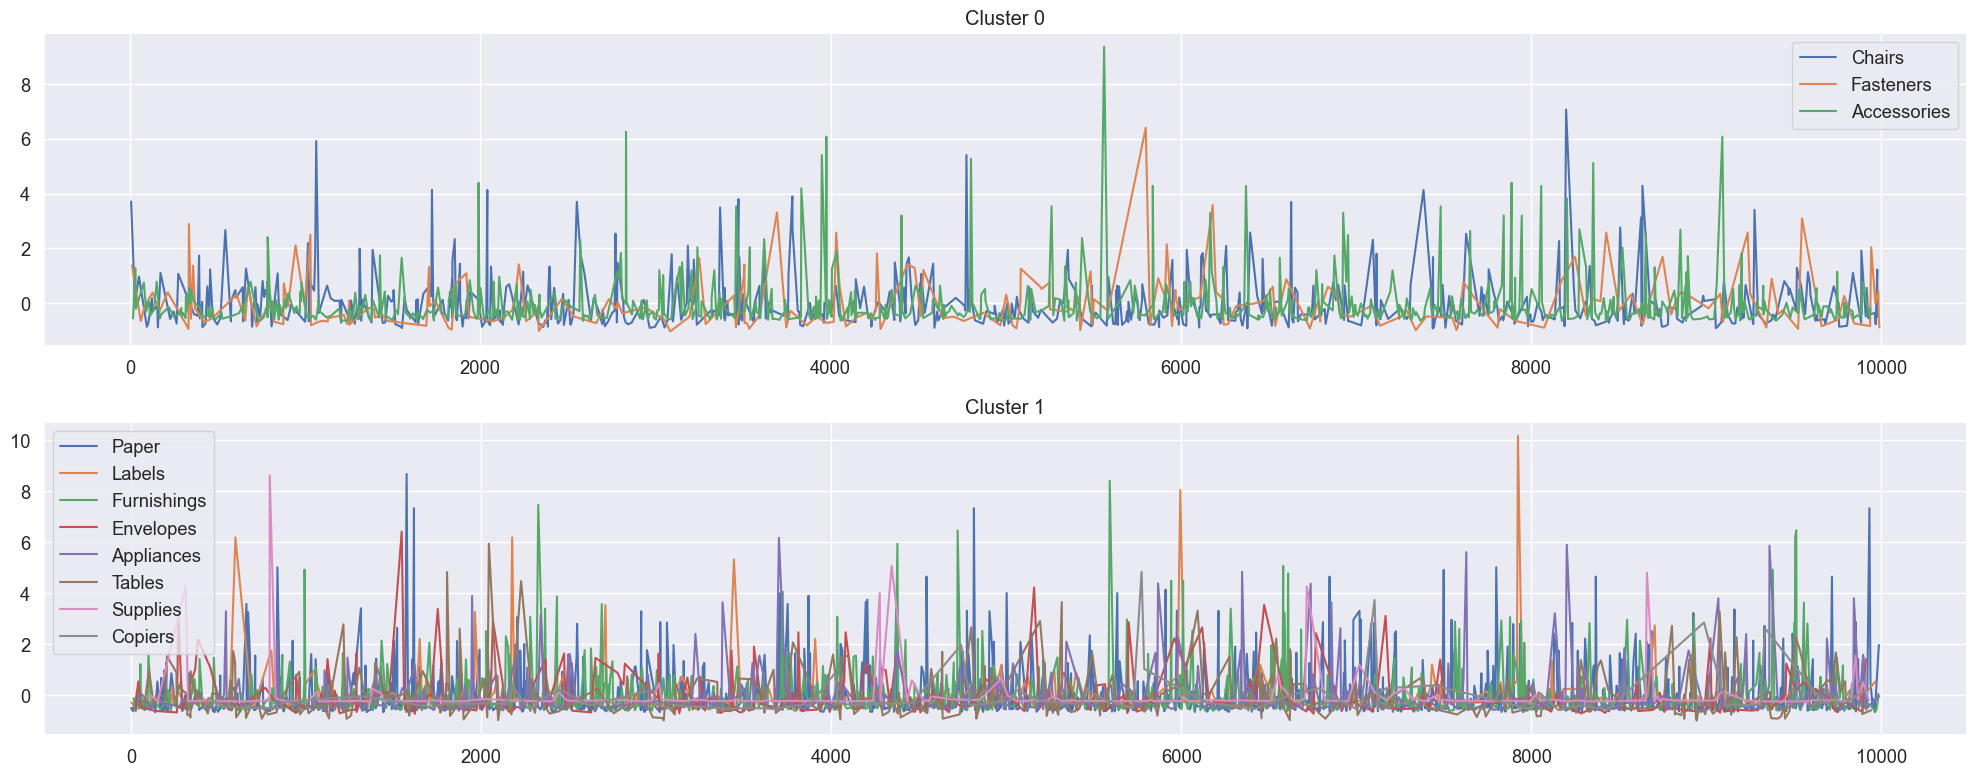

In [ ]:


clusters = sorted(data_w['cluster'].unique())
fig, axs = plt.subplots(nrows=len(clusters), ncols=1, figsize=(20, 8))
for cluster_id, ax in enumerate(axs):
    cluster_df = data_w[data_w['cluster'] == cluster_id]
    for subcategory in cluster_df['Sub-Category'].unique():
        subcat_df = cluster_df[cluster_df['Sub-Category'] == subcategory]
        ax.plot(z_normalize(subcat_df['Sales']), label=subcategory)
    ax.set_title(f'Cluster {cluster_id}')
    ax.legend()

plt.tight_layout() 
plt.show()

##### Clusters average viz

In [40]:
ave_dist = data_w[["cluster", "Sales", "Order Year"]].groupby(["Order Year", "cluster"]).agg({"Sales" : "mean"}).reset_index() # clusters average 
# ave_dist there is the question of normalization
fig3 = px.line(ave_dist, x="Order Year", y="Sales", color="cluster") # (Order Year vs Order_Date)
fig3.update_layout(plot_bgcolor='rgba(0,0,0,0)', )
fig3.update_xaxes(tickmode="array", tickvals=data_w['Order Year'].unique().tolist()) 
fig3.show()

##### Clusters average gender

In [43]:
ave_dist_g = data_w[["cluster", "Sales", "Order Year", "Gender"]].groupby(["Order Year", "cluster", "Gender"]).agg({"Sales" : "mean"}).reset_index() # clusters average 
fig = px.line(ave_dist_g, x="Order Year", y="Sales", color="cluster", facet_col="Gender") # (Order Year vs Order_Date)
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(tickmode="array", tickvals=data_w['Order Year'].unique().tolist()) 
fig.show()

In [44]:
ave_dist_g = data_w[["cluster", "Sales", "Order Year", "Gender", "Age"]].groupby(["Order Year", "Gender", "cluster"]).agg({"Age" : "mean"}).reset_index() # clusters average 
fig = px.bar(ave_dist_g, x='Order Year', y='Age', color='Gender', facet_col='cluster', barmode='group',
            #  labels={'Distance': 'Distance Metric', 'Score': 'Score', 'Metric': 'Clustering Metric'},
             title='Average Age & Gender Across Clusters')

fig.update_layout(
    xaxis_title='Order Year',
    yaxis_title='Age',
    legend_title='Gender'
)
fig.show()

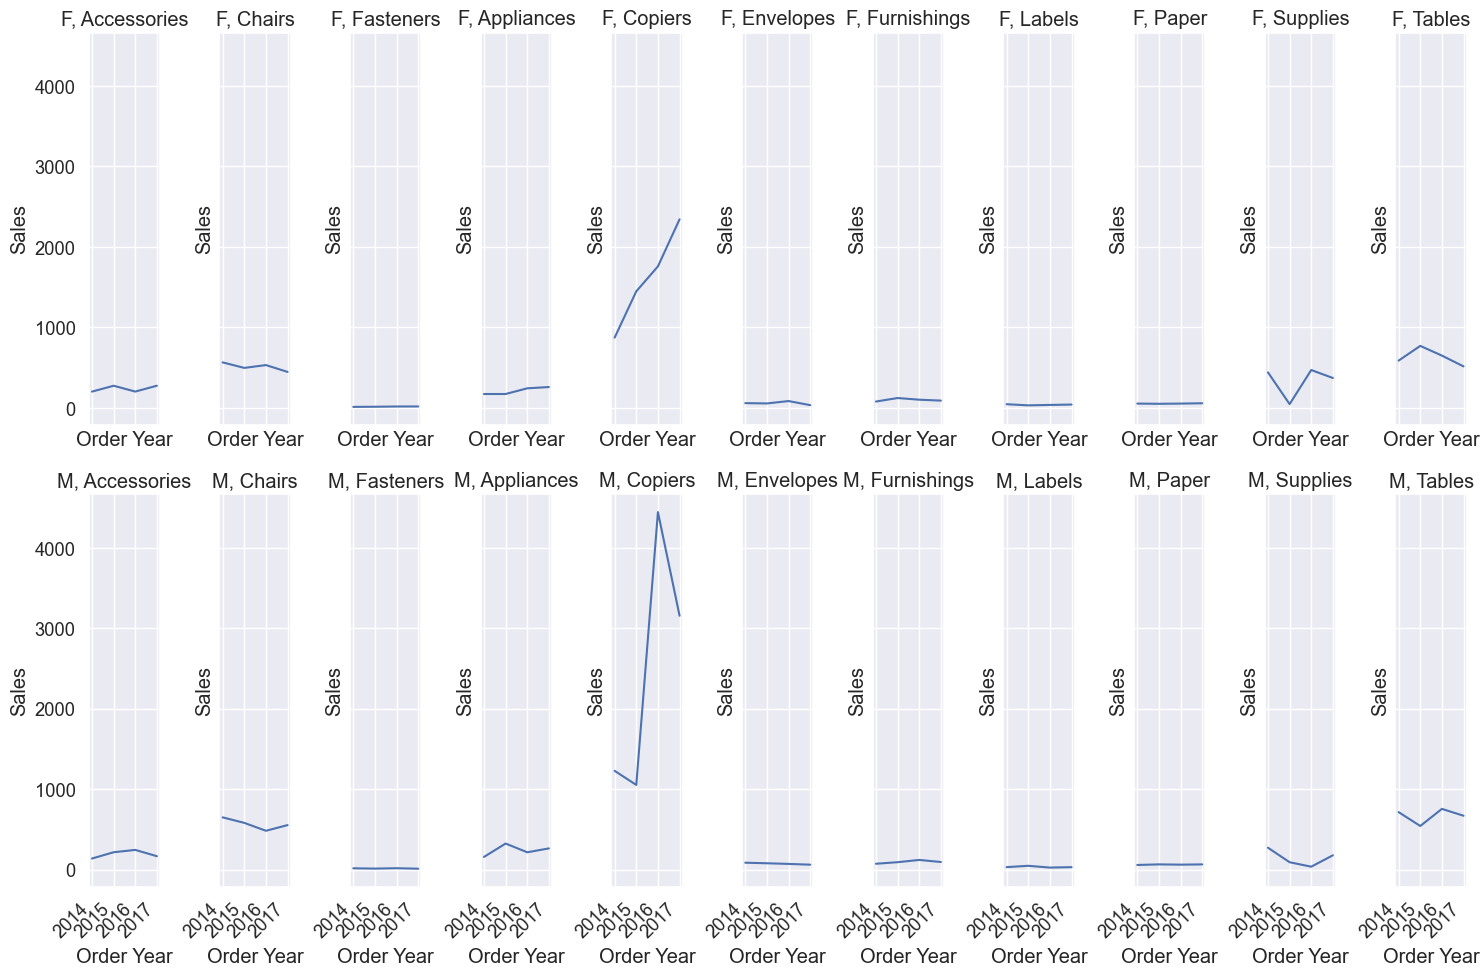

In [ ]:
ave_dist_g = data_w[["cluster", "Sales", "Order Year", "Gender", "Sub-Category"]].groupby(["Order Year", "cluster", "Gender", "Sub-Category"]).agg({"Sales" : "mean"}).reset_index() # clusters average 
fig, axes = plt.subplots(nrows=len(ave_dist_g['Gender'].unique()), 
                            ncols=len(ave_dist_g['Sub-Category'].unique()), 
                            figsize=(15, 10), 
                            sharex=True, sharey=True)

for i, gender in enumerate(ave_dist_g['Gender'].unique()):
    for j, sub_category in enumerate(ave_dist_g['Sub-Category'].unique()):
        filtered_df = ave_dist_g[(ave_dist_g['Gender'] == gender) & (ave_dist_g['Sub-Category'] == sub_category)] 
        axes[i, j].plot(filtered_df['Order Year'], filtered_df['Sales'])
        axes[i, j].set_title(f"{gender}, {sub_category}")
        axes[i, j].set_xlabel("Order Year")
        axes[i, j].set_ylabel("Sales")
        axes[i, j].set_xticks(range(min(filtered_df['Order Year']), max(filtered_df['Order Year']) + 1)) 
        plt.setp(axes[i, j].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

# ---
fig, axes = plt.subplots(nrows=len(ave_dist_g["Gender"].unique()), ncols=len(ave_dist_g['Sub-Category'].unique()),
                            figsize=(15, 10),
                            sharex=True, sharey=True)